## Compute parametric VaR

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
import datetime as dt
import pandas_datareader.data as web
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

start = dt.datetime(2010,1,1)
end = dt.datetime(2020,7,10)
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = 100 * sp500['Adj Close'].pct_change().dropna()

In [2]:
# Specify and fit a GARCH model
basic_gm = arch_model(returns, vol='Garch', p=1, q=1, mean='constant', dist='t')
gm_result = basic_gm.fit(disp='off')

#Make variance forecast
split_date = dt.datetime(2019,1,1)
gm_forecast = gm_result.forecast(start = split_date)

In [3]:
mean_forecast = gm_forecast.mean['2019-01-01':]
variance_forecast = gm_forecast.variance['2019-01-01':]

5% parametric quantile:  -1.5582205824240636


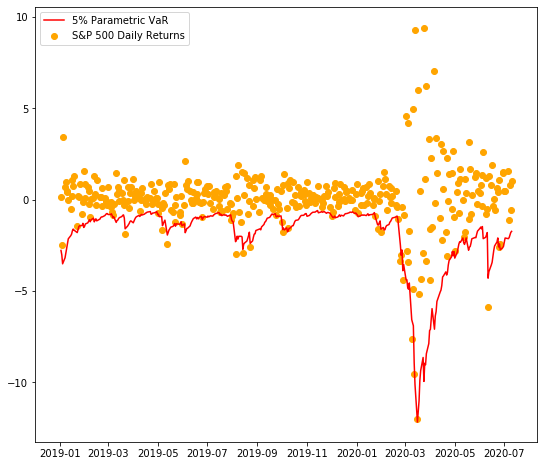

In [4]:
nu = gm_result.params.nu

# Obtain the parametric quantile
q_parametric = basic_gm.distribution.ppf(0.05, nu)
print('5% parametric quantile: ', q_parametric)
    
# Calculate the VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,returns['2019-1-1':], color = 'orange', label = 'S&P 500 Daily Returns' )
plt.legend(loc = 'upper left')
plt.show()

## Compute empirical VaR

The difference between parametric VaR and empirical VaR is how the quantiles are estimated. The parametric approach estimates quantiles from an assumed distribution assumption, while the empirical approach estimates quantiles from an observed distribution of the standardized residuals.

5% empirical quantile:  -1.7397491030123367


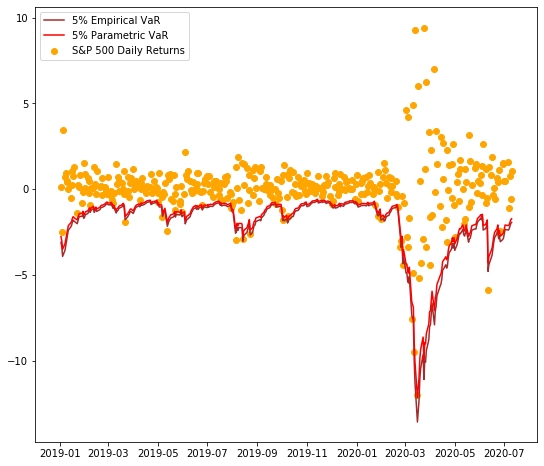

In [5]:
std_resid = gm_result.resid

# Obtain the empirical quantile
q_empirical = std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Calculate the VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
# Save VaR in a DataFrame
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot the VaRs
plt.plot(VaR_empirical, color = 'brown', label = '5% Empirical VaR')
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,returns['2019-1-1':], color = 'orange', label = 'S&P 500 Daily Returns' )
plt.legend(loc = 'upper left')
plt.show()

Overall both VaRs are very close, but the empirical VaRs have bigger loss estimations, which implies VaRs based on the theoretical Student’s t-distribution assumption may underestimate the downside risks.

## Compute GARCH covariance

Covariance describes the relationship of movement between two price return series. Recall dynamic covariance can be computed by ρ * σ1 * σ2, where σ1, σ2 are volatility estimates from GARCH models, and ρ is the simple correlation between GARCH standardized residuals.

In [6]:
eur = web.get_data_yahoo('EURUSD=X', start=start, end=end)
returns_eur = 100 * eur['Adj Close'].pct_change().dropna()

# Specify and fit a GARCH model
basic_eur = arch_model(returns_eur, vol='Garch', p=1, q=1, mean='constant', dist='t')
eur_result = basic_gm.fit(disp='off')
vol_eur = eur_result.conditional_volatility
resid_eur = eur_result.resid/vol_eur

In [7]:
cad = web.get_data_yahoo('CAD=X', start=start, end=end)
returns_cad = 100 * cad['Adj Close'].pct_change().dropna()

# Specify and fit a GARCH model
basic_cad = arch_model(returns_cad, vol='Garch', p=1, q=1, mean='constant', dist='t')
cad_result = basic_cad.fit(disp='off')
vol_cad = cad_result.conditional_volatility
resid_cad = cad_result.resid/vol_cad

In [8]:
resid_cad = resid_cad[resid_eur.index].fillna(resid_cad.mean())

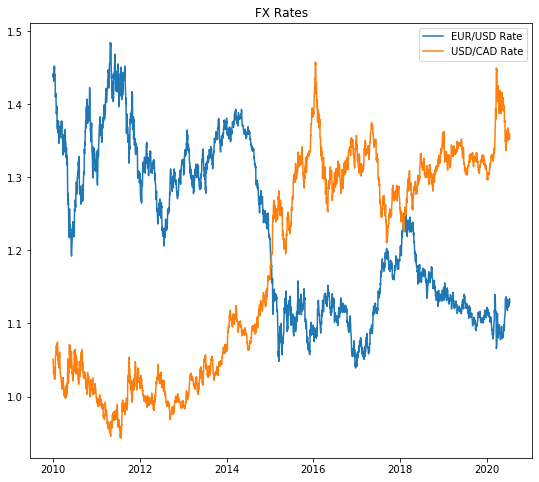

In [9]:
plt.plot(eur['Close'], label = 'EUR/USD Rate')
plt.plot(cad['Close'], label = 'USD/CAD Rate')
plt.legend()
plt.title('FX Rates')
plt.show()

Correlation:  -0.23952838980201432


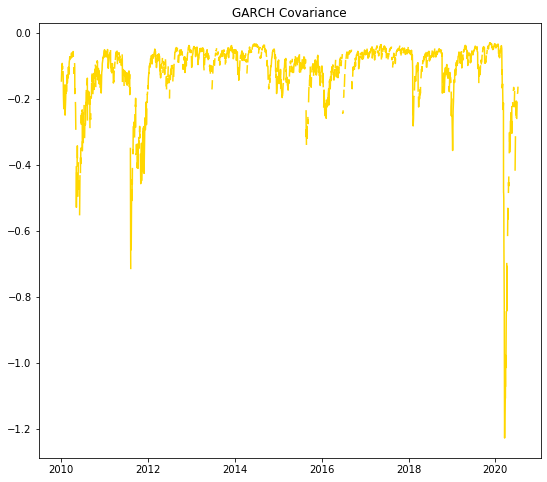

In [10]:
# Calculate correlation
corr = np.corrcoef(resid_eur, resid_cad)[0,1]
print('Correlation: ', corr)

# Calculate GARCH covariance
covariance =  vol_eur * vol_cad * corr

# Plot the data
plt.plot(covariance, color = 'gold')
plt.title('GARCH Covariance')
plt.show()

The EUR/USD and USD/CAD rates tend to move in the opposite directions, so their dynamic covariance is negative and fluctuating over time.

## Compute dynamic portfolio variance

The Modern Portfolio Theory states that there is an optimal way to construct a portfolio to take advantage of the diversification effect, so one can obtain a desired level of expected return with the minimum risk. This effect is especially evident when the covariance between asset returns is negative.

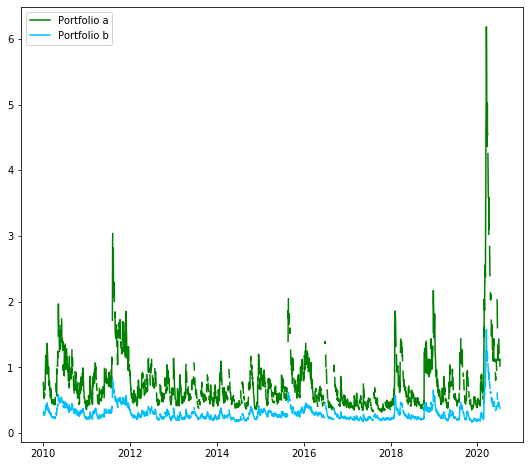

In [11]:
# Define weights
Wa1 = 0.9
Wa2 = 1 - Wa1
Wb1 = 0.5
Wb2 = 1 - Wb1

# Calculate portfolio variance
portvar_a = Wa1**2 * vol_eur + Wa2**2 * vol_cad + 2*Wa1*Wa2 *covariance
portvar_b = Wb1**2 * vol_eur + Wb2**2 * vol_cad + 2*Wb1*Wb2*covariance

# Plot the data
plt.plot(portvar_a, color = 'green', label = 'Portfolio a')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Portfolio b')
plt.legend(loc = 'upper left')
plt.show()

Portfolio b is much less volatile compared to portfolio a. Even just for a simple two-asset portfolio, how we structure it can greatly alter the risk profile.

In [12]:
start = dt.datetime(2011,1,1)

tesla = web.get_data_yahoo('TSLA', start=start, end=end)
returns_tesla = 100 * tesla['Adj Close'].pct_change().dropna()

# Specify and fit a GARCH model
basic_tesla = arch_model(returns_tesla, vol='Garch', p=1, q=1, mean='constant', dist='t')
tesla_result = basic_tesla.fit(disp='off')
vol_tesla = tesla_result.conditional_volatility
resid_tesla = tesla_result.resid/vol_tesla

In [13]:
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns_sp = 100 * sp500['Adj Close'].pct_change().dropna()

# Specify and fit a GARCH model
basic_sp = arch_model(returns_sp, vol='Garch', p=1, q=1, mean='constant', dist='t')
sp_result = basic_sp.fit(disp='off')
vol_sp = sp_result.conditional_volatility
resid_sp = sp_result.resid/vol_sp

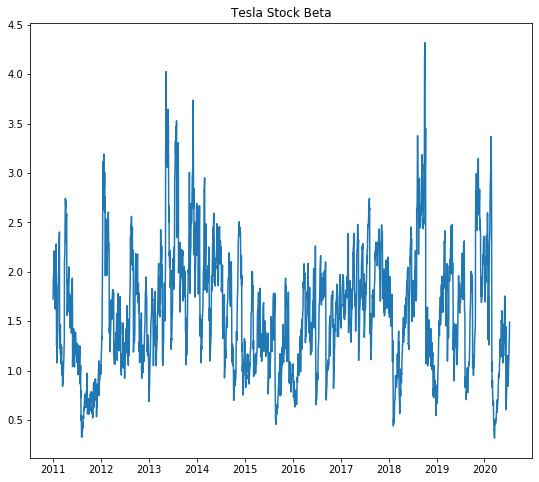

In [14]:
# Compute correlation between SP500 and Tesla
correlation = np.corrcoef(resid_tesla, resid_sp)[0, 1]

# Compute the Beta for Tesla
stock_beta = correlation * (vol_tesla / vol_sp)

# Plot the Beta
plt.title('Tesla Stock Beta')
plt.plot(stock_beta)
plt.show()